In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 降维(Dimensionality Reduction)

## 维度诅咒(curse of dimensionality)

Curse of dimensionality是由数学家Richard Bellman首次提出的，在给定的精度水平下，估计一个任意函数所需的样本数随函数的输入变量数（即维度）呈指数级增长。

在今天的大数据世界里，当数据有大量的维度时，维度诅咒会给机器学习带来麻烦：
1. 过拟合

虽估计参数量的增加，模型估计的方差也会增加。如果模型估计的偏差和训练集的大小不变，随着维度的上升，估计参数的质量也会下降，因为估计的方差增加。
如果我们的特征比观测值多，我们就会面临大规模过拟合模型的风险--这通常会导致糟糕的样本外性能。

2. 稀疏性

数据的指数增长导致数据集的高稀疏性，即代表的空间量激增，数据跟不上，从而变得稀疏。

3. 欧式距离

$n$维超立方体（hypercube）内超球体（hypersphere）所占空间的百分比

$$
\frac{\pi^{n / 2}}{2^{n} \Gamma\left(\frac{n}{2}+1\right)} * 100
$$
当$n$值较高的情况下，上述数量趋向于接近零，这说明越来越多的数据开始集中在超立方体的角落（即向单一维度），这不仅增加了稀疏性，而且使距离函数变得“无效”。


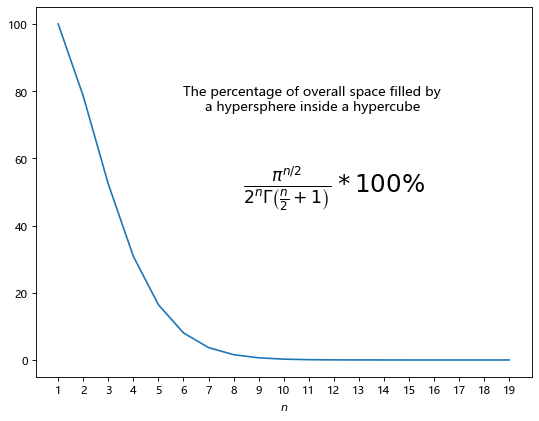

In [3]:
from scipy.special import gamma

n = np.arange(1, 20)

plt.figure(figsize=(8,6), dpi=80)
plt.plot(n, (np.pi**(n/2))/(2**n*gamma(n/2+1))*100)
plt.text(6, 70,("The percentage of overall space filled by\n" "a hypersphere inside a hypercube\n"),
        multialignment="center", fontsize=12)
plt.text(12, 50, r"$\frac{\pi^{n / 2}}{2^{n} \Gamma\left(\frac{n}{2}+1\right)} * 100\%$", ha="center", fontsize=22)

plt.xlabel("$n$"); plt.xticks(n,n);


在2D中，有两个圆，红色实线圆的半径1，虚线紫色线圆半径0.95，半径仅仅差0.05，虚实线之间环假设为边界，其所占面积并不大，占到$5\%$，落在边界区间的数据也不是很多。
保持这两个半径，在三维，是个球体，这边界区间占球体体积的$1-0.95^2=9.75\%$。当更高维度时，也就是个超球体，当100维的时候，边界体积占超球体体积的$1-0.95^{100}=99.41\%$。如果样本是在球体内均匀分布的，这也意味着，在高维情况，大量数据分布在高维的边界内，而不是内球内。这边界作为分类的间隔面，也就说大量样本难以区分。此外，在高维情况下数据也会变得稀疏。

$$V \sim c r^d$$

$$
\frac{\Delta V}{V_0}=\frac{V_0 - V_1}{V_0}=
\frac{c \cdot r_0^d - c \cdot r_1^d}{c \cdot r_0^d}=1-\left(\frac{r_1}{r_0}\right)^d
$$

(-1.2, 1.2)

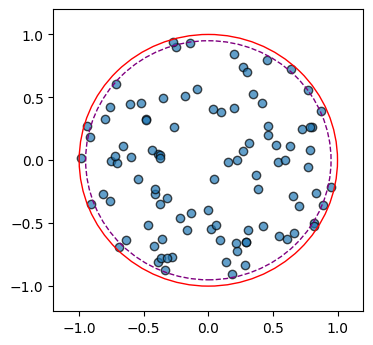

In [53]:
rnd = np.random.RandomState(42)
X = rnd.uniform(-1, 1, size=(150,2))
X = X[(X**2).sum(axis=1)<=1][0:100]

plt.figure(figsize=(4, 4), dpi=100)


eps = 0.2

ax = plt.gca()

ax.add_artist(plt.Circle((0,0), 1, fill=False, ec="red"))
ax.add_artist(plt.Circle((0,0), 0.95, fill=False, ec="purple", ls="--"))
ax.scatter(X[:,0], X[:,1], ec="k", alpha=0.7)
ax.set_xlim(-1 - eps, 1 + eps)
ax.set_ylim(-1 - eps, 1 + eps)

### Hughes（休斯） 现象

随着维度的增加，分类器的性能也在增加，直到我们达到最佳的特征数量。在不增加训练样本数量的情况下，进一步增加维度会导致分类器性能下降。


<CENTER>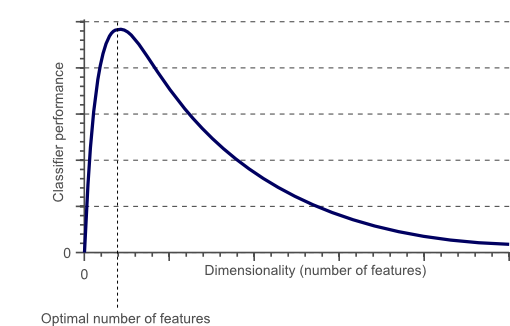</CENTER>


## 主成分分析(Principal Component Analysis, PCA)

PCA(Principal Component Analysis)，即主成分分析方法，是一种使用最广泛的数据降维算法。PCA的主要思想是将$n$维特征的空间**线性变换**到一个$k$维空间上，这个$k$维空间是由新构造出的$k$个正交特征构成，这些正交特征称之为**主成分**。

线性变换可以理解为，将一个空间变换到另一空间，或将空间变形，变换经过一系列的旋转，镜像(翻转)，伸缩（缩放），推移（错切）等变形操作，而且新旧空间依然保持下面特征：
1. 变换前后，原点保持不变
2. 变换前后，平行且等距的直线依然是平行等距。

PCA的工作原理就是从原始的空间中顺序地找一组相互正交的坐标轴，新的坐标轴的选择与数据本身是密切相关的。其中，第一个新坐标轴选择是原始数据中方差最大的方向，第二个新坐标轴选取是与第一个坐标轴正交的平面中使得方差最大的，第三个轴是与第1,2个轴正交的平面中方差最大的。依次类推，可以得到n个这样的坐标轴。

<table><tr>
    <td>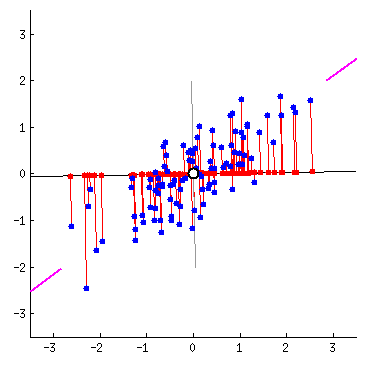</td>
    <td>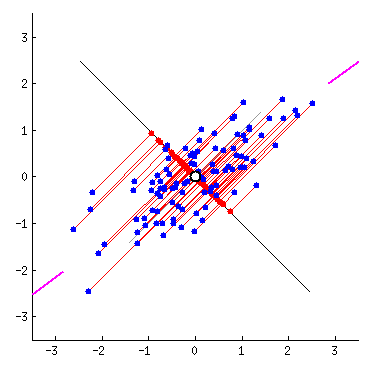</td>
</tr></table>

### PCA的数学原理

两个随机变量$X$和$Y$的协方差
$$
\mathrm{Cov}\left(X,Y\right) 
= \mathbb{E}\left[(X-\mathbb{E}X)(Y-\mathbb{E}Y) \right]
= \mathbb{E}\left(XY\right) - \mathbb{E}X\mathbb{E}Y
$$

$n$个随机变量$X_1, X_2, \dots, X_n$彼此协方差构成协方差矩阵$\Sigma$

$$
\Sigma
= \begin{bmatrix}
 \mathrm{E}[(X_1 - \mu_1)(X_1 - \mu_1)] & \mathrm{E}[(X_1 - \mu_1)(X_2 - \mu_2)] & \cdots & \mathrm{E}[(X_1 - \mu_1)(X_n - \mu_n)] \\
 \mathrm{E}[(X_2 - \mu_2)(X_1 - \mu_1)] & \mathrm{E}[(X_2 - \mu_2)(X_2 - \mu_2)] & \cdots & \mathrm{E}[(X_2 - \mu_2)(X_n - \mu_n)] \\
 \vdots & \vdots & \ddots & \vdots \\
 \mathrm{E}[(X_n - \mu_n)(X_1 - \mu_1)] & \mathrm{E}[(X_n - \mu_n)(X_2 - \mu_2)] & \cdots & \mathrm{E}[(X_n - \mu_n)(X_n - \mu_n)]
\end{bmatrix}
$$
其中，$\mu_i=\mathbb{E}X_i, i=1\dots n$

<br>
为了方便起见,$\mu_1=\mu_2=\dots=\mu_n=0$，协方差矩阵$\Sigma$简化为
$$
\Sigma
= \begin{bmatrix}
 \mathbb{E}{X_1 X_1} & \mathbb{E}X_1X_2 & \cdots & \mathbb{E} X_1 X_n  \\
 \mathbb{E}{X_2X_1}  & \mathbb{E}X_2X_2 & \cdots & \mathbb{E} X_2 X_n  \\
 \vdots & \vdots & \ddots & \vdots \\
 \mathbb{E}{X_n X_1} & \mathbb{E}X_nX_2 & \cdots & \mathbb{E} X_nX_n
\end{bmatrix}
$$

## <br><br>
中心化的数据矩阵$X_{m\times n}$，$m$行样本数据（这里中心化是指每列特征均值为$0$），每个样本$n$列特征，那么这$n$个特征的协方差矩阵
$$
C = \frac{X^\top X}{m-1}
$$

> 

<br>
假设主成分(principal component)的向量$w$，数据$X$投射到主成分$w$，得到$Xw$，之所以叫做主成分，数据在主成分上投影是方差最大的，这个最优化可以表示为下式：

$$
\begin{aligned}
\max_w \mathrm{Var}(Xw) &= \max_w \frac{(Xw)^T(Xw)}{m-1}  \\
\text{subject to} \;\: \:& w^{\top}w = 1.
\end{aligned}
$$

求解上式，带等式约束条件的优化，使用拉格朗日乘子法，变为：
$$ \max_w \; \frac{(Xw)^{\top}(Xw)}{m-1} - \lambda ( w^{\top}w - 1)   $$

上式对向量$w$求导，得到
$$ \frac{2X^{\top}X}{m-1}w - 2\lambda w = 0 $$

得到
$$ \frac{X^{\top}X}{m-1}w = \lambda w \;\Longrightarrow\; Cw = \lambda w $$

上式$X^{\top}X$是一个$n\times n$的方阵，满足$Cw = \lambda w$行式，$\lambda$和$w$分别就是特征值(eigenvalue)和特征向量(eigenvector)，
而且分别有$n$个特征值和特征向量。也就是说，主成分向量就是数据$X$的协方差矩阵的特征向量。
> 注意，上面数据矩阵$X$，$m$个样本，有$n$列特征，此处“特征”英文是feature,中文翻译恰巧一样，切记不要弄混）

<br>
定义特征向量矩阵$W$和特征值对角矩阵$\Lambda$
$$
W = \left(w_1 \,  w_2 \, \dots \, w_n\right),
\;\quad
 \Lambda = \begin{bmatrix}
   \lambda_{1} &  &  & \\ 
   & \lambda_{2} &  & \\ 
   &  &  \ddots & \\ 
   &  &   & \lambda_{n} 
 \end{bmatrix}
$$
特征矩阵因为由$n$个特征向量构成，所以特征矩阵可逆，得到
$$C W = W \Lambda  \;\Longrightarrow\;  C = W \Lambda W^{-1}  $$


### 对iris数据集进行PCA分解转换

IRIS数据集鸢尾花亚种分类数据集，数据有4个特征花瓣长、宽和花萼长、宽。

In [4]:
from sklearn.datasets import load_iris
iris = load_iris()

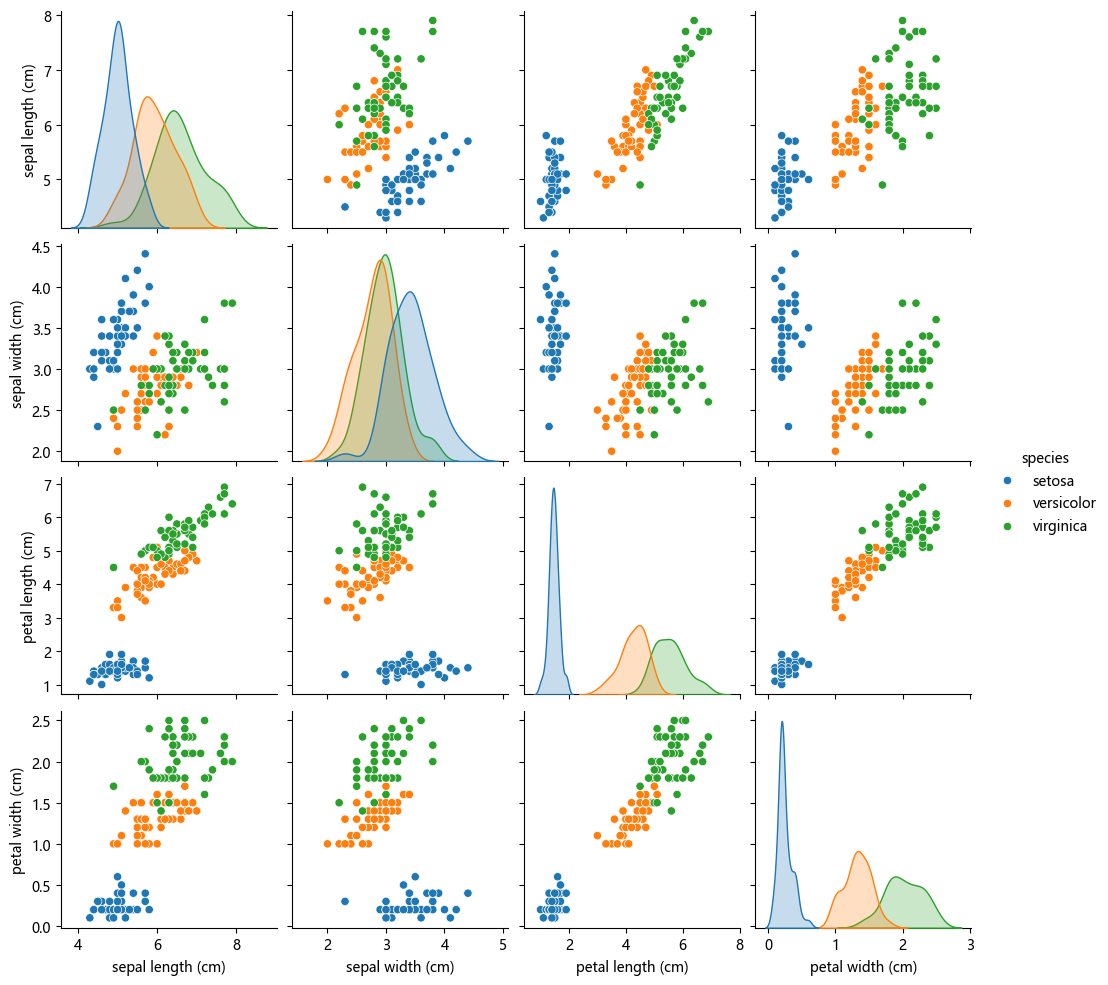

In [5]:
sns.pairplot(pd.concat([
    pd.DataFrame(iris.data, columns=iris.feature_names),
    pd.DataFrame({"species": iris.target_names[iris.target]})
], axis=1), hue="species");

In [6]:
X.shape

(150, 4)

In [8]:
A = np.arange(1, 10).reshape(3, -1)
A

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [12]:
w, x = np.linalg.eig(A) # 求特征值(eigen values)和特征向量(eigen vectors)
w

array([ 1.61168440e+01, -1.11684397e+00, -1.30367773e-15])

In [13]:
x

array([[-0.23197069, -0.78583024,  0.40824829],
       [-0.52532209, -0.08675134, -0.81649658],
       [-0.8186735 ,  0.61232756,  0.40824829]])

In [18]:
np.isclose(A @ x[:, 0], w[0] * x[:, 0])

array([ True,  True,  True])

$$
A = X \Lambda X^{-1}
$$

In [26]:
w

array([ 1.61168440e+01, -1.11684397e+00, -1.30367773e-15])

In [28]:
x

array([[-0.23197069, -0.78583024,  0.40824829],
       [-0.52532209, -0.08675134, -0.81649658],
       [-0.8186735 ,  0.61232756,  0.40824829]])

In [30]:
x_inv = np.linalg.inv(x)
x_inv

array([[-0.48295226, -0.59340999, -0.70386772],
       [-0.91788599, -0.24901003,  0.41986593],
       [ 0.40824829, -0.81649658,  0.40824829]])

In [27]:
x @ np.diag(w) @ x_inv

array([[1., 2., 3.],
       [4., 5., 6.],
       [7., 8., 9.]])

In [42]:
A1 = x[:, [0]] @ x_inv[[0],:]
A2 = x[:, [1]] @ x_inv[[1],:]
A3 = x[:, [2]] @ x_inv[[2],:]

In [44]:
w[0] * A1

array([[1.80558242, 2.21854359, 2.63150476],
       [4.08893187, 5.02412601, 5.95932015],
       [6.37228132, 7.82970843, 9.28713554]])

In [45]:
w[0] * A1 + w[1] * A2

array([[1., 2., 3.],
       [4., 5., 6.],
       [7., 8., 9.]])

In [46]:
w[0] * A1 + w[1] * A2 + w[2] * A3

array([[1., 2., 3.],
       [4., 5., 6.],
       [7., 8., 9.]])

In [51]:
np.round(w, 10)

array([16.11684397, -1.11684397, -0.        ])

In [7]:
from sklearn.decomposition import PCA

X = iris.data

pca = PCA()
pca.fit(X)

X_pc = pca.transform(X)

In [7]:
X.shape

(150, 4)

In [5]:
X_pc.shape

(150, 4)


#### `PCA`拟合结果可用的属性
* `components_` 返回具有最大方差的成分。
* `explained_variance_ratio_` 返回所保留的n个成分各自的方差百分比。
* `n_components_` 返回所保留的成分个数n。
* `mean_`
* `noise_variance_`

#### `PCA`方法
* `transform(X)`  将数据X转换成降维后的数据
* `inverse_transform(X_new)`  将降维后的数据转换成原始数据



 

<br>
下面绘制PCA获得四个主成分的两两散点图。

> 这里需要注意，一般情况，我们不会绘制主成分之后的散点图，为什么？<br>
> 因为按理论，主成分与主成分之间是正交的,线性无关的。例如，在上图很容发现存在某个线性关系，但是下图就没有。

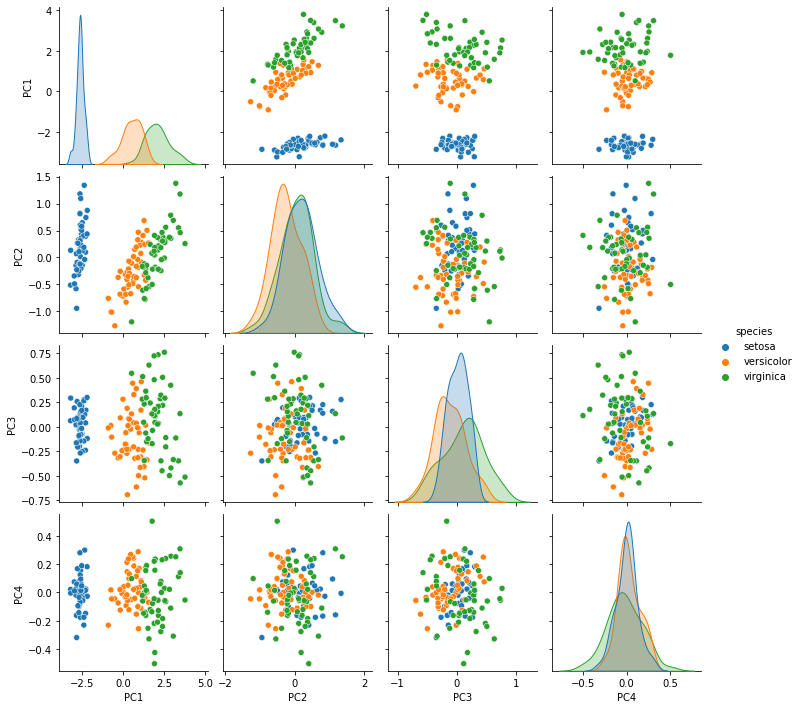

In [4]:
sns.pairplot(pd.concat([
    pd.DataFrame(X_pc, columns=[f"PC{i+1}" for i in range(4)]),
    pd.DataFrame({"species": iris.target_names[iris.target]})
], axis=1), hue="species");

In [13]:
pca.explained_variance_

array([4.22824171, 0.24267075, 0.0782095 , 0.02383509])

<br>


> PCA依赖于数据的协方差矩阵。如果数据没有被标准化，具有较大数值范围的特征可能会主导主成分的形成，掩盖其他特征的信息。标准化可以确保每个特征对主成分的贡献相等。

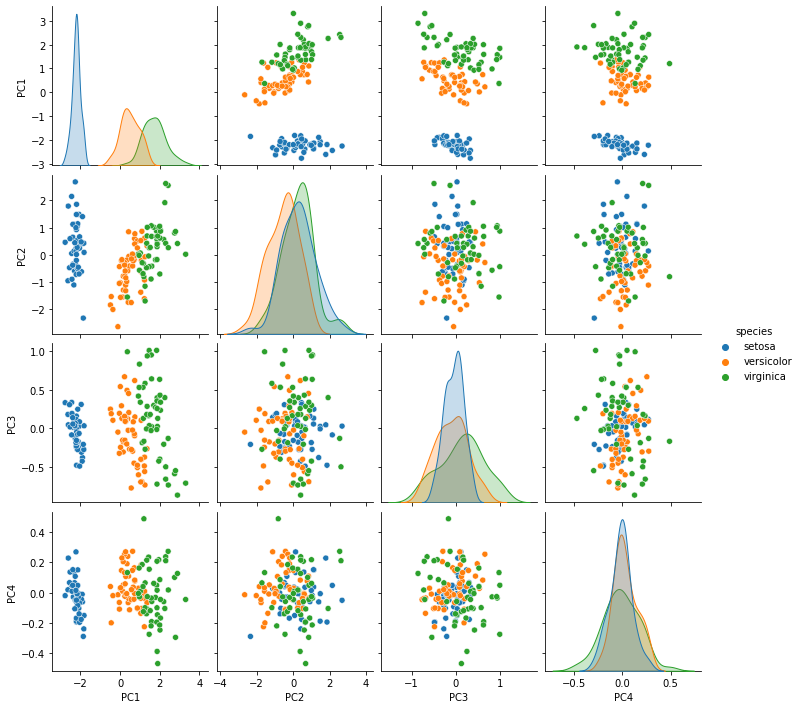

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

std_pca = make_pipeline(StandardScaler(), PCA())
std_pca.fit(X)

X_stdpc = std_pca.transform(X)

sns.pairplot(pd.concat([
    pd.DataFrame(X_stdpc, columns=[f"PC{i+1}" for i in range(4)]),
    pd.DataFrame({"species": iris.target_names[iris.target]})
], axis=1), hue="species");

In [12]:
std_pca.named_steps.pca.explained_variance_

array([2.93808505, 0.9201649 , 0.14774182, 0.02085386])

<br>
四个数据特征的方差和协方差:

In [9]:
iris.data.shape

(150, 4)

In [107]:
iris.data.var(axis=0, ddof=1).round(decimals=4)

array([0.6857, 0.19  , 3.1163, 0.581 ])

In [104]:
np.cov(iris.data.T).round(decimals=4)

array([[ 0.6857, -0.0424,  1.2743,  0.5163],
       [-0.0424,  0.19  , -0.3297, -0.1216],
       [ 1.2743, -0.3297,  3.1163,  1.2956],
       [ 0.5163, -0.1216,  1.2956,  0.581 ]])

<br>
数据主成分分析转换后，四个主成分方差和协方差

In [108]:
X_pc.var(axis=0, ddof=1).round(decimals=4)

array([4.2282, 0.2427, 0.0782, 0.0238])

In [103]:
np.cov(X_pc.T).round(decimals=4)

array([[ 4.2282,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.2427, -0.    ,  0.    ],
       [ 0.    , -0.    ,  0.0782, -0.    ],
       [ 0.    ,  0.    , -0.    ,  0.0238]])

<br>

原数据四个特征的方差比例，在进行PCA之后，获得了四个主成分，每个主成分的方差比例

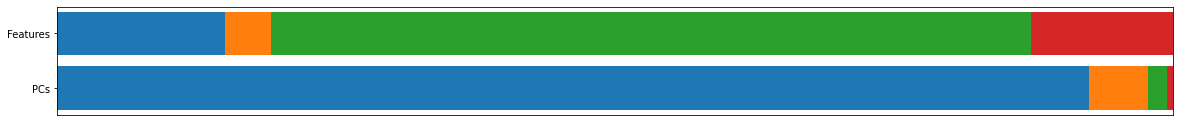

In [88]:
plt.figure(figsize=(20,2))
groups = np.vstack([X_pc.var(axis=0), iris.data.var(axis=0)]).T
Pos = range(len(groups[0]))
for i in range(len(groups)):
    plt.barh(Pos, groups[i], left = np.sum(groups[:i], axis = 0))
plt.yticks([1, 0], ["Features", "PCs"])
plt.xticks(())
plt.xlim((0, groups.sum(axis=0).max()));

sklearn的[PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)的结果`components_`


<br>
注意：

> 在学统计时，方差估计样本存在有偏和无偏之分，样本减去样本均值的平方之和，再除以N是有偏估计，除以N-1则是无偏。Numpy的`var`函数计算的方差估计默认是除以N的，这也就是为什么前面`var`设置了`ddof=1`参数，其意思要除以`N - ddof`，即除以N-1，采用方差的无偏估计。参数`ddof`是“Delta Degrees of Freedom”的意思。


<br>

`PCA`结果
* `components_`是一个矩阵，每一个行向量就是主成分向量，在特征数据中主成分向量的表示，主成分向量按照对应方差从大到小排列。
* `explained_variance_`是一个向量，对应主成分的方差

In [4]:
pca.components_

array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ],
       [ 0.65658877,  0.73016143, -0.17337266, -0.07548102],
       [-0.58202985,  0.59791083,  0.07623608,  0.54583143],
       [-0.31548719,  0.3197231 ,  0.47983899, -0.75365743]])

In [23]:
pca.explained_variance_.round(decimals=4)

array([4.2282, 0.2427, 0.0782, 0.0238])

<br>

利用numpy“手工”计算主成分分析的$C$、$W$和$\Lambda$

In [16]:
X_means = X.mean(axis=0)
X0 = X - X_means

C = X0.T @ X0 / (len(X0) - 1) # 计算协方差

print("covariance: ")
print(C.round(decimals=4))

lambdas, W = np.linalg.eig(C) # 计算矩阵特征值和特征向量

print("\nlambdas= ")
print(lambdas.round(decimals=4))

print("\nW= ")
print(W.round(decimals=4))

covariance: 
[[ 0.6857 -0.0424  1.2743  0.5163]
 [-0.0424  0.19   -0.3297 -0.1216]
 [ 1.2743 -0.3297  3.1163  1.2956]
 [ 0.5163 -0.1216  1.2956  0.581 ]]

lambdas= 
[4.2282 0.2427 0.0782 0.0238]

W= 
[[ 0.3614 -0.6566 -0.582   0.3155]
 [-0.0845 -0.7302  0.5979 -0.3197]
 [ 0.8567  0.1734  0.0762 -0.4798]
 [ 0.3583  0.0755  0.5458  0.7537]]


<br>
上面注意到通过sklearn的`PCA`计算的主成分向量与我们自己使用numpy计算的特征向量，存在部分向量虽然数值相同但其符号不同，这个差别是因为向量方向相反。

> 任何检验两个向量是否平行？
> 假设$a$和$b$两个向量，其内积如下式：<br>
>> 点积几何意义可理解：一个向量投影到另一个向量上的长度与该向量长度乘积。
>
> $$a\cdot b = \lVert a \rVert \cdot \lVert b \rVert \cos \theta $$
> 其中$\theta$为向量$a$和$b$的夹角。特别的，若两向量方向相同则$\cos\theta=1$，若相反则$\cos\theta=-1$，若正交则$\cos\theta=0$。
> <br>
> 此外，向量$x$的长度（欧式距离）定义为
> $$ \lVert x \rVert = \sqrt{a\cdot a}$$

<br>

下面分别计算numpy计算的`W`的特征向量与`pca.components_`的主成分向量的夹角余弦值

In [124]:
cosvalue = lambda a,b: (a @ b) /np.sqrt((a @ a) * (b @ b))

np.array([cosvalue(W[:,i],  pca.components_.T[:,i]).round() for i in range(len(W))])

array([ 1., -1.,  1., -1.])

上面结果要么$1$要么$-1$说明两个向量要么相同要么相反

<br>

使用`pca.transform(X)`，将`X`转换成主成分空间的数据；将`pca.inverse_transform`转换主成分空间转换回原空间

<br>
将$X$转换成主成分的向量空间
$$X' = (X-\mu) W$$

将$X'$转换回$X$
$$ X = X' W^{\top} + \mu $$
这里$$W^{\top} = W^{-1}$$




In [172]:
np.abs(pca.inverse_transform(pca.transform(X)) - X).sum()

3.170519402573291e-13

In [129]:
X_pc1 = pca.transform(X)

# X_pc2 = (X - X_means) @ W
X_pc2 = (X - X_means) @ pca.components_.T

np.array([
    cosvalue(X_pc1[i,:],  X_pc2[i,:]).round(2) 
    for i in range(len(X_pc1))
])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [173]:
X_pc2 = (X - X_means) @ W

X2 = X_pc2 @ W.T + X_means

np.abs(X2 - X).sum()

2.2618018569176002e-13

## 补充内容：奇异值分解(SVD, Singular value decomposition)

主成分分析在前面使用了协方差矩阵特征值分解的思路。这个方法并不是唯一方法，其实这个方法并不常用，常用方法是SVD（奇异值分解）。

所谓矩阵奇异值分解，对于任意的矩阵$X_{m \times n}$，可以分解为三个矩阵的乘积
$$
X_{m\times n} = U_{m\times m} \Sigma_{m\times n}  V^{*}_{n\times n}
$$
其中$U$是$m\times m$阶酉矩阵，$V$是$n\times n$阶酉矩阵， $V^*$是$V$的共轭转置，$\Sigma$是$m\times n$阶非负实数对角矩阵。

> 所谓酉(yǒu)矩阵$U$(unitary matrix)，是一个$m$阶复数方阵（方阵元素可由实数扩展到复数），且满足
$$UU^*=U^*U=I^{m}$$
也就说，$U$是一个可逆阵，且其逆矩阵就是其共轭转置
$$U^*=U^{-1}$$
此外，矩阵$U$的共轭转置定义为
$$U^* = (\overline{U})^{\top} = \overline{U^{\top}}$$
而且，若酉矩阵的元素都是实数，该阵即为正交矩阵，无论行向量还是列向量都正交，实数酉矩阵转置也是其逆矩阵。


均值为零数据矩阵$X_{m\times n}$（m条样本，n列特征）的协方差矩阵$C$，
$$
C = \frac{X^{\top}X}{m-1} = \frac{ (U\Sigma V^*)^{\top} (U\Sigma V^*) }{m-1} 
=\frac{ (V \Sigma  U ^{\top}) (U \Sigma V^{\top}) }{m-1} 
=\frac{ V \Sigma  (U ^{\top} U) \Sigma V^{\top} }{m-1}
=\frac{ V \Sigma^2 V^{\top} }{m-1}
$$

对比前面
$$
C=\frac{ V \Sigma^2 V^{\top} }{m-1}=W \Lambda W^{-1} 
$$
得到
$$
\begin{aligned}
\Lambda &= \frac{\Sigma^2}{m-1} \\
W &= V \\
W^{-1} &= V^{\top} 
\end{aligned}
$$

In [9]:
X_means = X.mean(axis=0)
X0 = X - X_means

U, S, Vt = np.linalg.svd(X0, full_matrices=False)

In [13]:
S**2/(len(X)-1)

array([4.22824171, 0.24267075, 0.0782095 , 0.02383509])

In [17]:
Vt.T

array([[ 0.36138659, -0.65658877,  0.58202985,  0.31548719],
       [-0.08452251, -0.73016143, -0.59791083, -0.3197231 ],
       [ 0.85667061,  0.17337266, -0.07623608, -0.47983899],
       [ 0.3582892 ,  0.07548102, -0.54583143,  0.75365743]])


<br>

## 案例：肿瘤数据主成分分析


In [52]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

# 将恶性肿瘤表示为1，良性肿瘤表示0
cancer.target = 1 - cancer.target 
cancer.target_names = list(reversed(cancer.target_names))

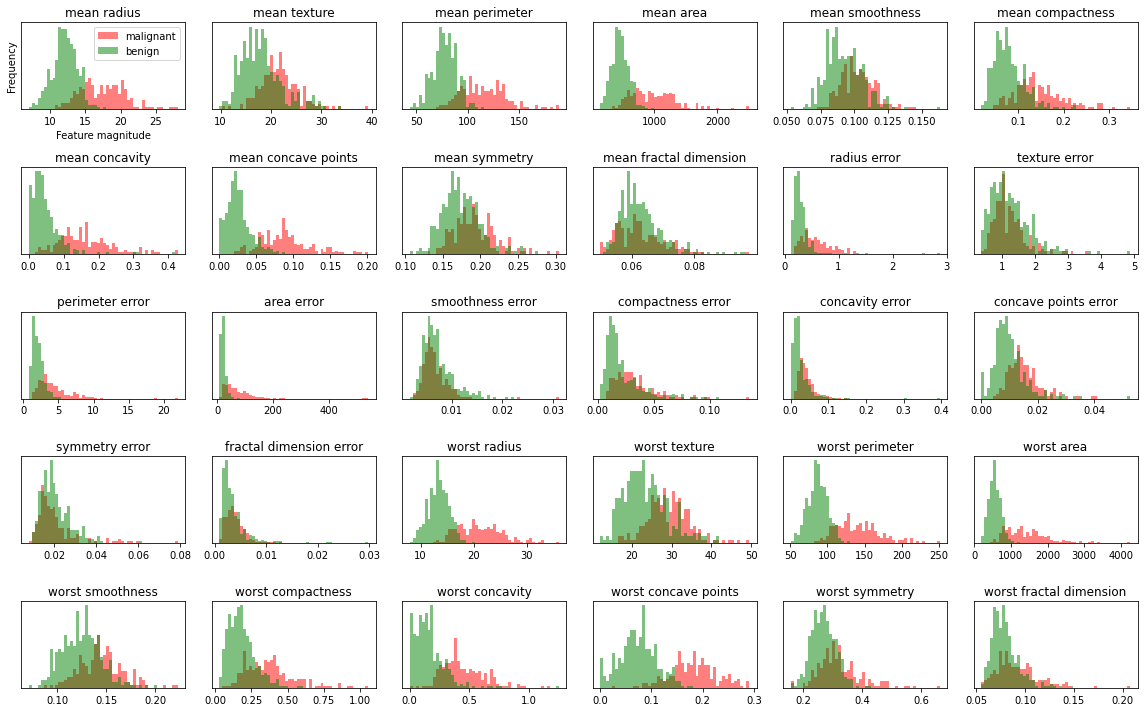

In [17]:
fig, axes = plt.subplots(5, 6, figsize=(16, 10))
malignant = cancer.data[cancer.target == 1]
benign = cancer.data[cancer.target == 0]

ax = axes.ravel()

for i in range(30):
    _, bins = np.histogram(cancer.data[:, i], bins=50)
    ax[i].hist(malignant[:, i], bins=bins, color="red", alpha=.5)
    ax[i].hist(benign[:, i], bins=bins, color="green", alpha=.5)
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())
    
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(["malignant", "benign"], loc="best")
fig.tight_layout()

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

pipepca = make_pipeline(StandardScaler(), PCA(n_components=2))
pipepca.fit(cancer.data)


X_pca = pipepca.transform(cancer.data)

print(f"Original shape: ", cancer.data.shape)
print(f"Reduced shape:  ", X_pca.shape)

Original shape:  (569, 30)
Reduced shape:   (569, 2)


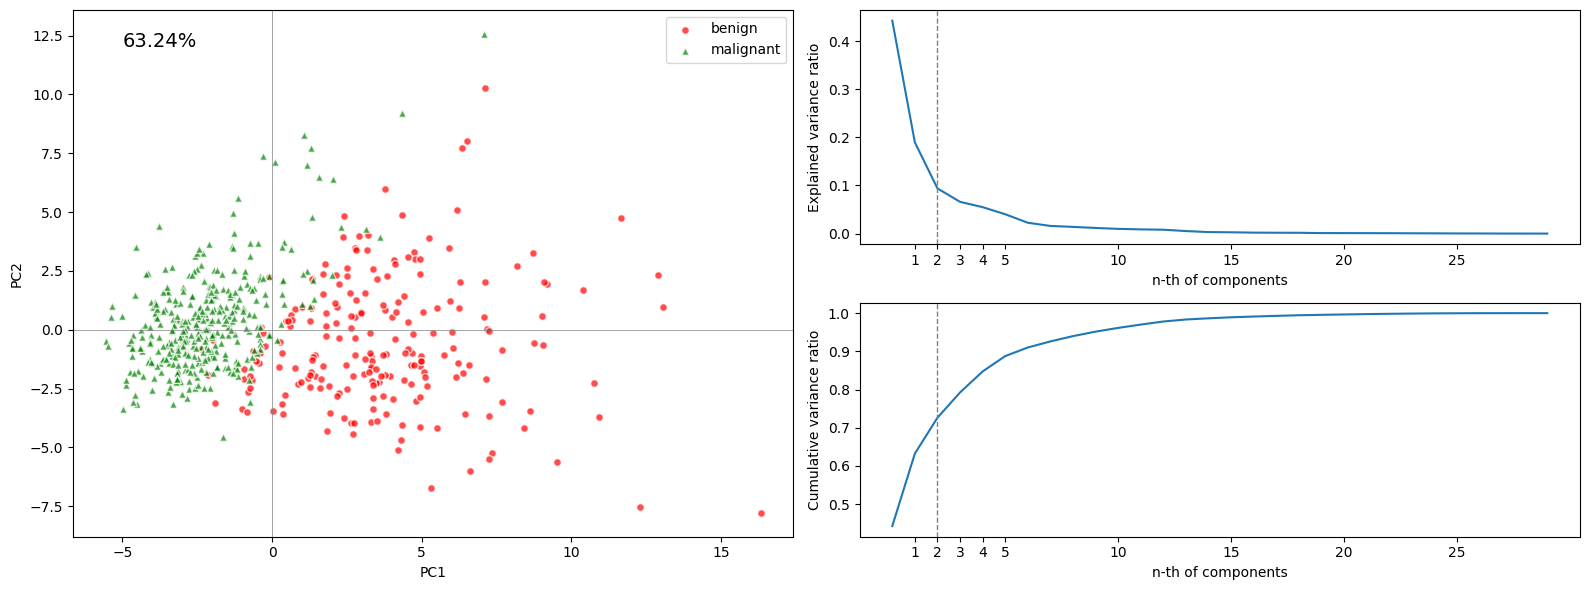

In [83]:
pca_all = make_pipeline(StandardScaler(), PCA()).fit(cancer.data)
X_pcall = pca_all.transform(cancer.data)

fig = plt.figure(figsize=(16, 6), dpi=100)

gspec = fig.add_gridspec(ncols=6, nrows=2, height_ratios=[1.5, 1.5])

ax = fig.add_subplot(gspec[:2, :3])
ax.axhline(0, c="grey", lw=0.5); ax.axvline(0, c="grey", lw=0.5);
ax.scatter(X_pcall[cancer.target==1, 0], X_pcall[cancer.target==1, 1], 
            marker='o', s=30, ec="w", alpha=0.7, c="red", label=cancer.target_names[0])  
ax.scatter(X_pcall[cancer.target==0, 0], X_pcall[cancer.target==0, 1], 
            marker='^', s=30, ec="w", alpha=0.7, c="green", label=cancer.target_names[1])

ax.text(-5, 12, f"{pca_all.named_steps.pca.explained_variance_ratio_[:2].sum()*100:0.2f}%", size=14)
ax.set_xlabel("PC1"); ax.set_ylabel("PC2");
ax.legend(loc="best")

#---------------------------------------------
ax = fig.add_subplot(gspec[0, 3:])
ax.plot(pca_all.named_steps.pca.explained_variance_ratio_)
ax.axvline(2, c="grey", lw=1, ls="--")
ax.set_xlabel("n-th of components"); ax.set_ylabel("Explained variance ratio");
ticks = np.r_[np.arange(1,5), np.arange(5, 30, 5)]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)

#---------------------------------------------
ax = fig.add_subplot(gspec[1, 3:])
ax.plot(pca_all.named_steps.pca.explained_variance_ratio_.cumsum())
ax.axvline(2, c="grey", lw=1, ls="--")
ax.set_xlabel("n-th of components"); ax.set_ylabel("Cumulative variance ratio");
ticks = np.r_[np.arange(1,5), np.arange(5, 30, 5)]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)


fig.tight_layout()

<br>

从下图可以看出，随着投在主成分维度的数据方差越来越小，投在主成分维度的数据分布也变得又瘦又高。注意虽然在图中我们区分了红色恶性和绿色良性，但是数据分布的方差是没有区别对待的，但我们注意到随着数据方差变小，恶性和良性的区分度也变得小的数据现象，这为我们使用前几个重要的主成分提供了新的依据。

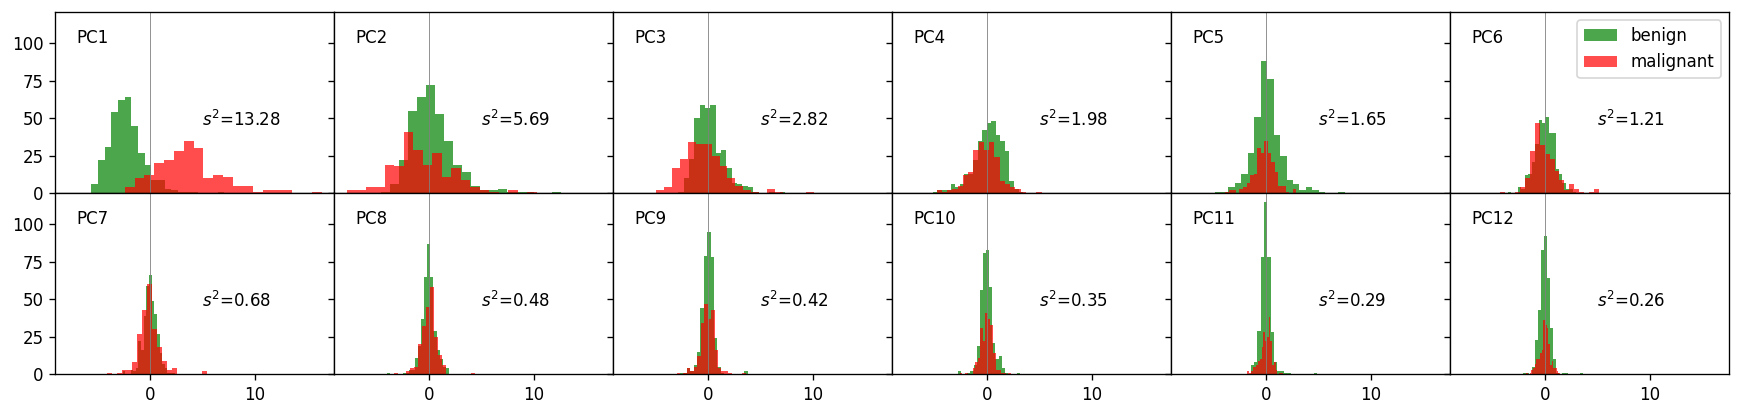

In [70]:
fig, axes = plt.subplots(2, 6, figsize=(18,4), dpi=120, 
                         sharex=True, sharey=True, 
                         gridspec_kw={"hspace": 0, "wspace": 0})

for j in range(2):
    for k in range(6):
        ax = axes[j][k]
        i = j*6 + k
        pc_ = X_pcall[:,i].reshape(-1,1)

        ax.hist(pc_[cancer.target==0], bins=20, alpha=0.7, color="green", label=cancer.target_names[0])
        ax.hist(pc_[cancer.target==1], bins=20, alpha=0.7, color="red", label=cancer.target_names[1])

        ax.axvline(0, c="grey", lw=0.5);
        ax.text(5, 45, f"$s^2$={pc_.var():0.02f}")
        ax.text(-7, 100, f"PC{i+1}")
        
axes[0][5].legend(loc="best")

plt.show()

In [127]:
np.argwhere((phi > 90) & (phi <= 180)).ravel()

array([ 4,  9, 14, 15, 18, 24, 29])

In [130]:
phi[lable_idxs]

array([117.03816928,  95.3681769 ,  97.91758882, 122.36729878,
       118.21646645, 175.65103197, 126.10850284])

In [144]:
phi

array([ 40.83964928,  75.5838537 ,  95.3681769 ,  97.91758882,
       117.03816928, 118.21646645, 122.36729878, 126.10850284,
       175.65103197, 180.10110838, 182.94796403, 202.33402966,
       204.8594138 , 206.72713218, 207.04579721, 207.54628288,
       207.54760945, 207.56344544, 207.5767781 , 207.5906876 ,
       207.59923571, 207.63371036, 207.78126715, 207.87825623,
       207.87932495, 207.91944874, 210.22128517, 211.55855213,
       216.63982773, 229.87930829])

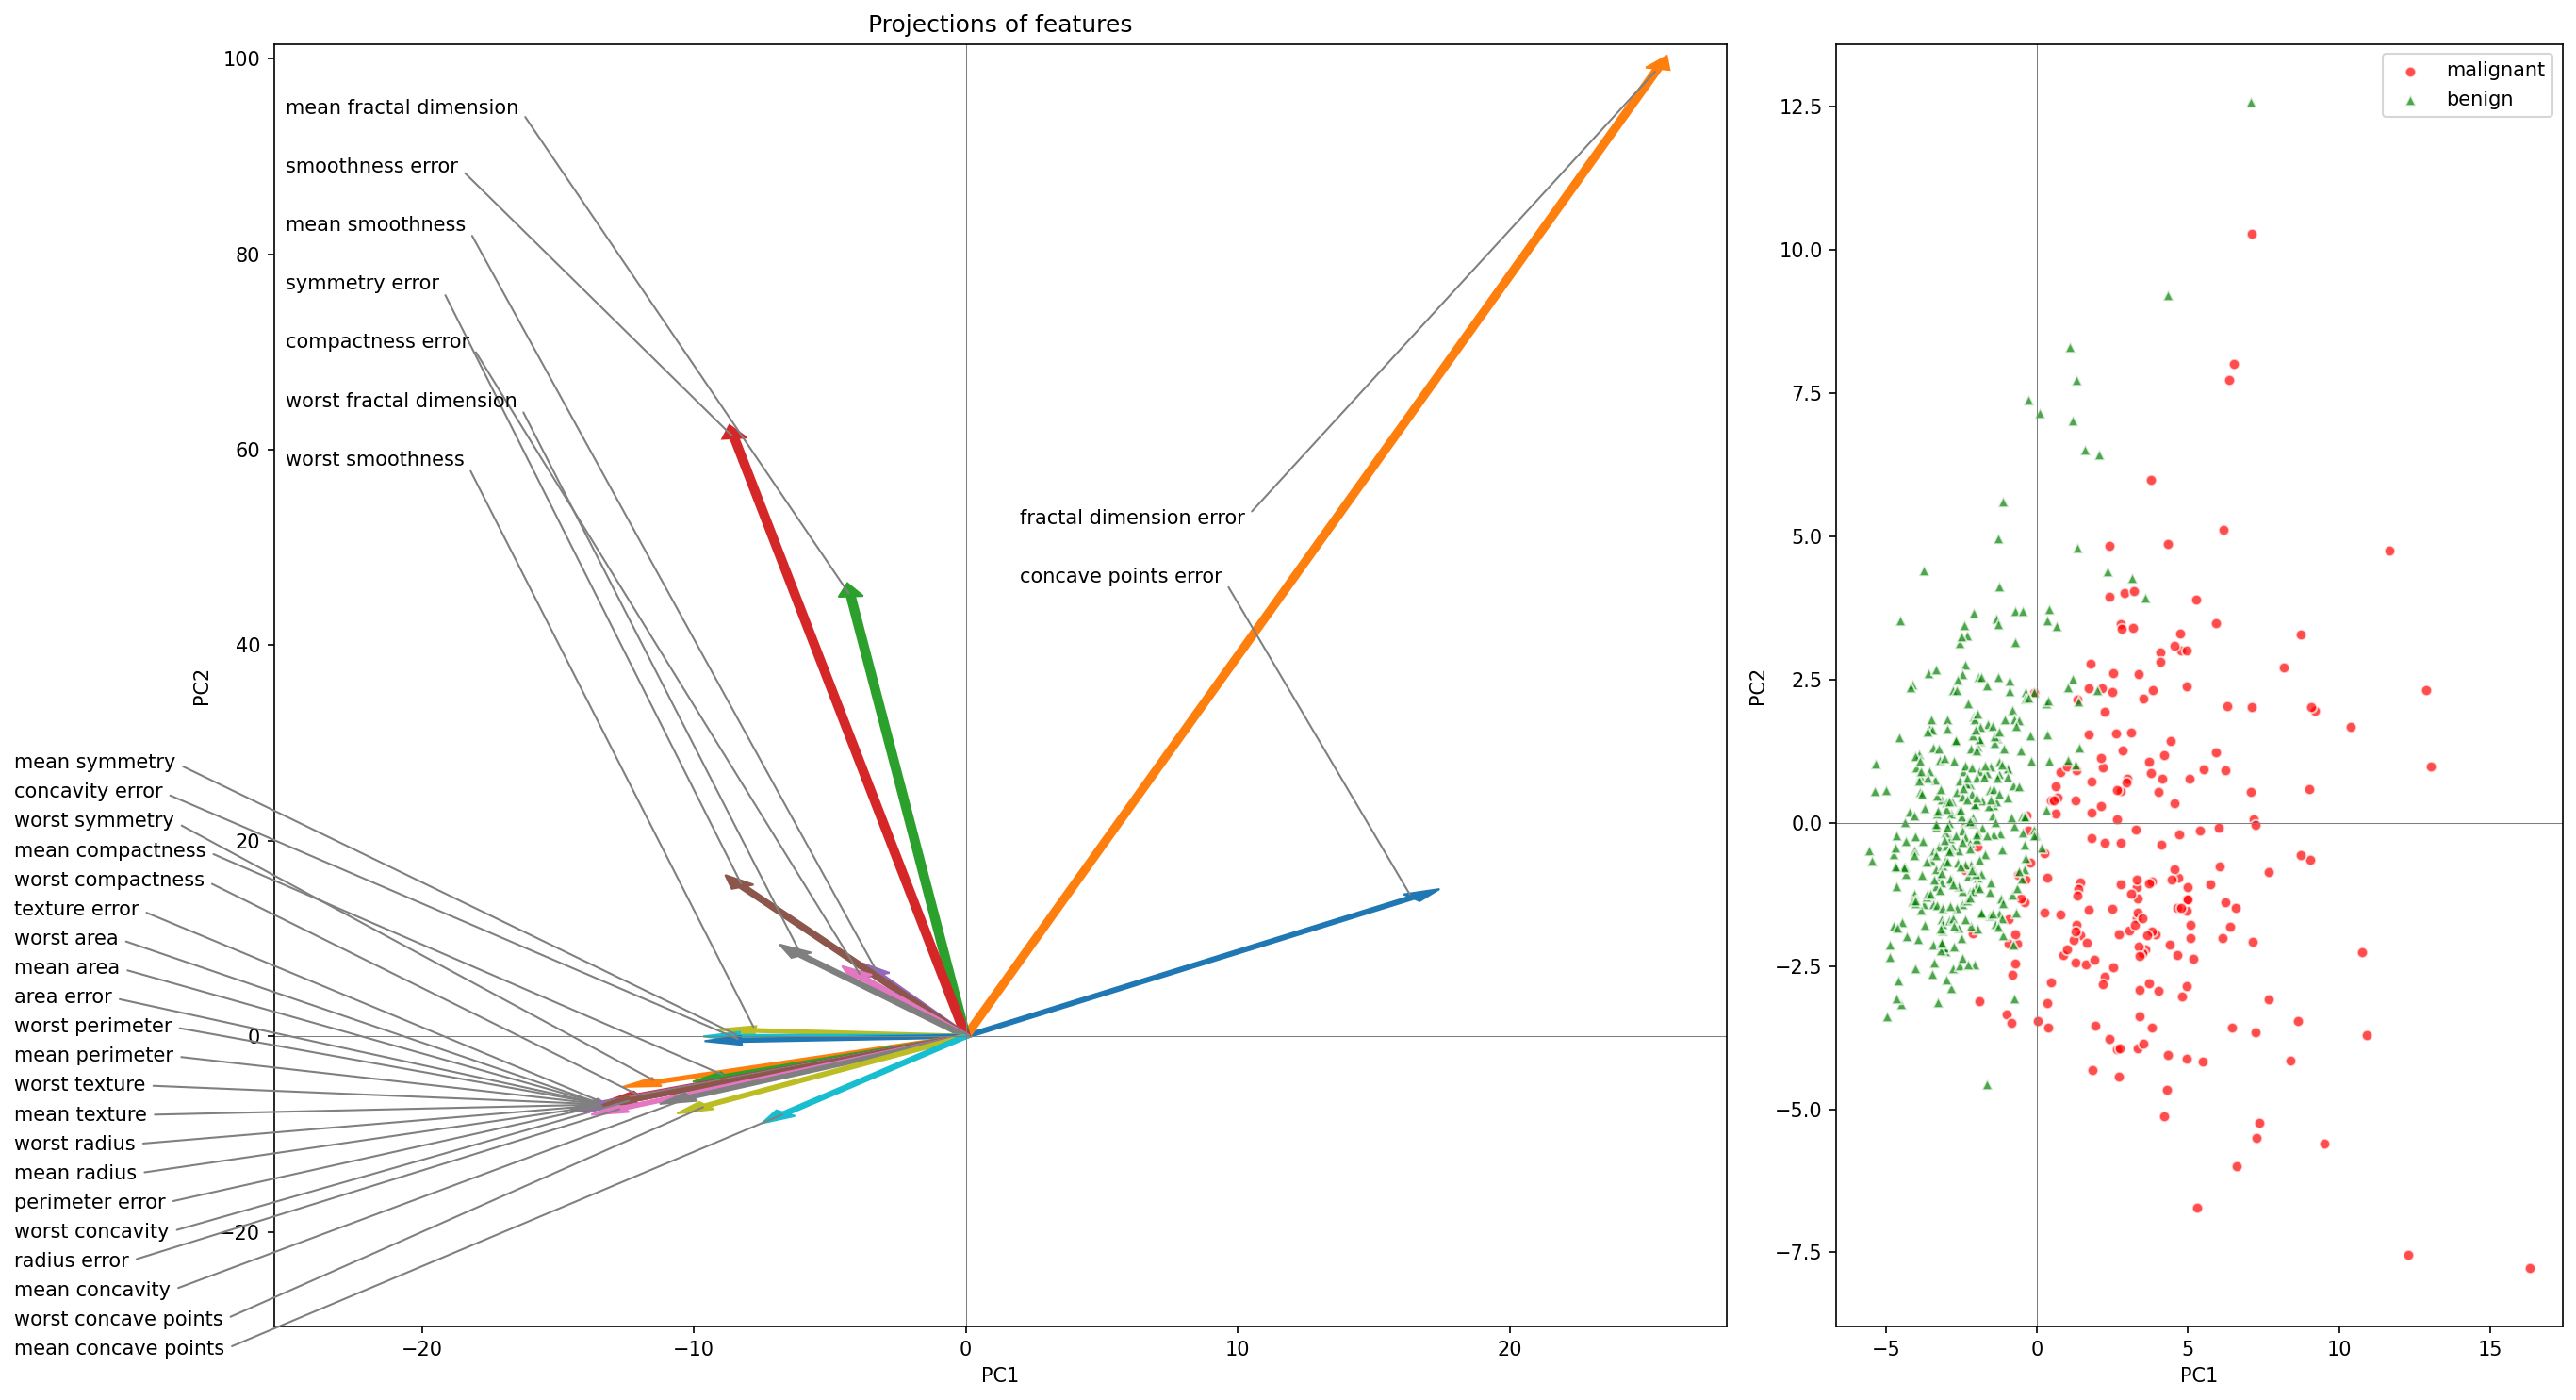

In [181]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

pipepca = make_pipeline(StandardScaler(), PCA(n_components=2))
pipepca.fit(cancer.data)

X_pca = pipepca.transform(cancer.data)

n_features = cancer.data.shape[1]

fig, axes = plt.subplots(1, 2, figsize=(18, 10), dpi=150,  gridspec_kw={'width_ratios':[2,1]})

ax = axes[1]
ax.axhline(0, c="grey", lw=0.5); ax.axvline(0, c="grey", lw=0.5);
ax.scatter(X_pca[cancer.target==1, 0], X_pca[cancer.target==1, 1], 
            marker='o', s=30, ec="w", alpha=0.7, c="red", label=cancer.target_names[1])  
ax.scatter(X_pca[cancer.target==0, 0], X_pca[cancer.target==0, 1], 
            marker='^', s=30, ec="w", alpha=0.7, c="green", label=cancer.target_names[0])
ax.set_xlabel("PC1"); ax.set_ylabel("PC2");
ax.legend(loc="best")


ax = axes[0]
ax.axhline(0, lw=0.5, c="grey"); ax.axvline(0, lw=0.5, c="grey")

# 将数据空间单位向量投影到主成分空间
eye_scaled = pipepca.transform(np.eye(n_features, n_features)) 

# phi表示单位向量投影在PC1和PC2象限内的角度
phi = np.arctan2(eye_scaled[:,1], eye_scaled[:,0])
phi = (np.where(phi >=0, 0, 2*np.pi) + phi)/(2*np.pi)*360 # 将[-pi,pi]转换为[0,360]
phi_idxs = np.argsort(phi)

# 将投影的向量按照逆时针排列
phi = phi[phi_idxs]
eye_scaled = eye_scaled[phi_idxs]
feature_names = [cancer.feature_names[i] for i in phi_idxs]

xmax = np.abs(eye_scaled[:,0]).max()
ymax = np.abs(eye_scaled[:,1]).max()
ax.set_xlim(-xmax , xmax + 0.1*xmax)
ax.set_ylim(-ymax + 0.7*ymax , ymax + 0.1*xmax)

text_xy = eye_scaled*1.2
# 排列第一象限的特征名称
lable_idxs = np.argwhere((phi > 0) & (phi <= 90)).ravel()
text_xy[lable_idxs,0] = np.array([2])
text_xy[lable_idxs,1] = 40 + (np.ones(len(lable_idxs)) * 6).cumsum()
# 排列第二象限的特征名称
lable_idxs = np.argwhere((phi > 90) & (phi <= 180)).ravel()
text_xy[lable_idxs,0] = np.array([-25])
text_xy[lable_idxs,1] = 100 - (np.ones(len(lable_idxs)) * 6).cumsum()
# 排列第三象限的特征名称
lable_idxs = np.argwhere((phi > 180) & (phi <= 270)).ravel()
text_xy[lable_idxs,0] = np.array([-35])
text_xy[lable_idxs,1] = 30 - (np.ones(len(lable_idxs)) * 3).cumsum()

for i in range(n_features):
    x, y = eye_scaled[i, 0], eye_scaled[i,1]
    color = plt.cm.tab10((i%10)/10)
    ax.arrow(0, 0, x, y, width=0.3, ec=color, fc=color) 
    ax.annotate(f"{feature_names[i]}", 
                xy=(x, y), xycoords='data', 
                xytext=(text_xy[i,0], text_xy[i,1]),
                horizontalalignment='left', verticalalignment='bottom', 
                arrowprops=dict(arrowstyle="-", 
                                fc="grey", ec="grey", 
                                ls="-", 
                                relpos=(1, 0.5)
                               ))
    
ax.set_title("Projections of features")
ax.set_xlabel("PC1"); ax.set_ylabel("PC2");

plt.tight_layout();

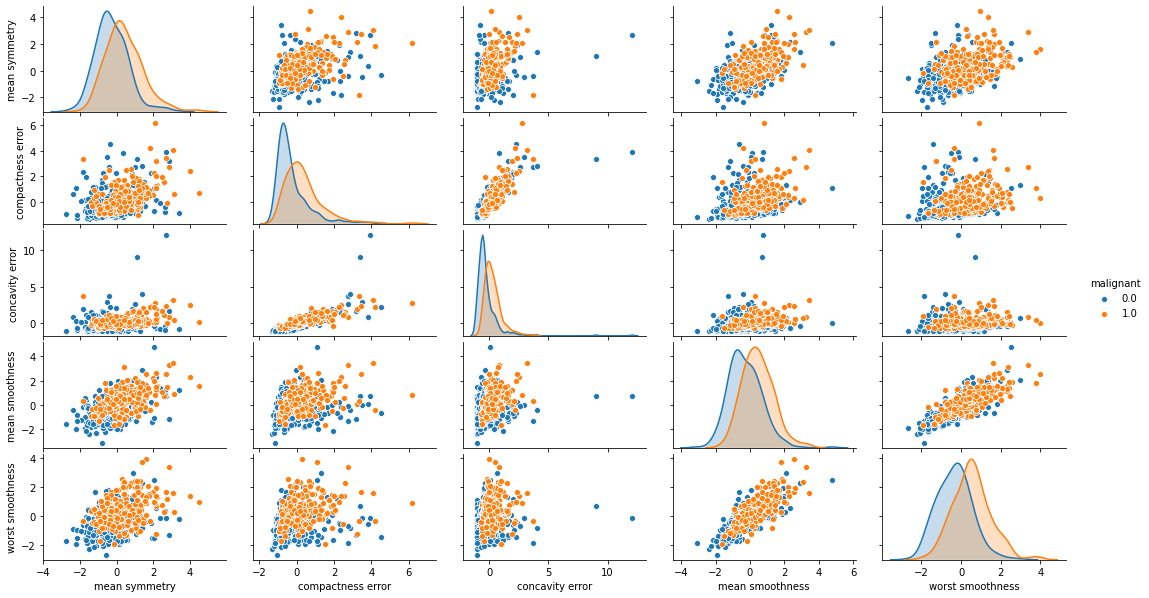

In [444]:
import pandas as pd
cancer_df = pd.DataFrame(np.c_[cancer.target, X_scaled], columns=["malignant"] + list(cancer.feature_names))

import seaborn as sns

cols = ["malignant", "mean symmetry","compactness error", "concavity error", "mean smoothness", "worst smoothness"]
g = sns.pairplot(cancer_df.loc[:, cols], hue="malignant")
g.fig.set_figwidth(16)
g.fig.set_figheight(8);

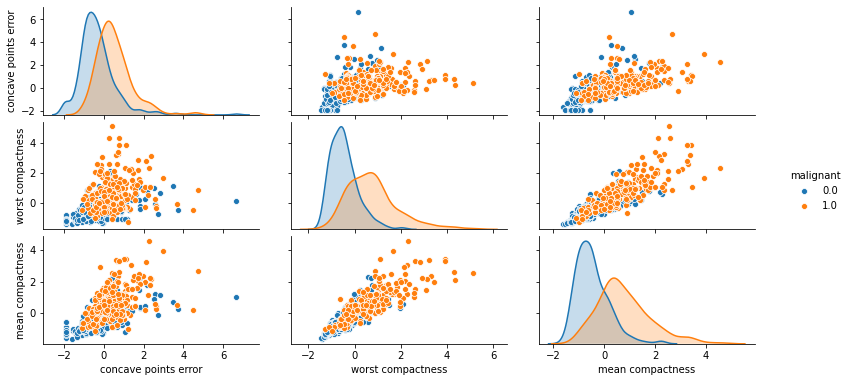

In [445]:
cols = ["malignant", 'concave points error', 'worst compactness', 'mean compactness']
g = sns.pairplot(cancer_df.loc[:, cols], hue="malignant")
g.fig.set_figwidth(12)
g.fig.set_figheight(5);

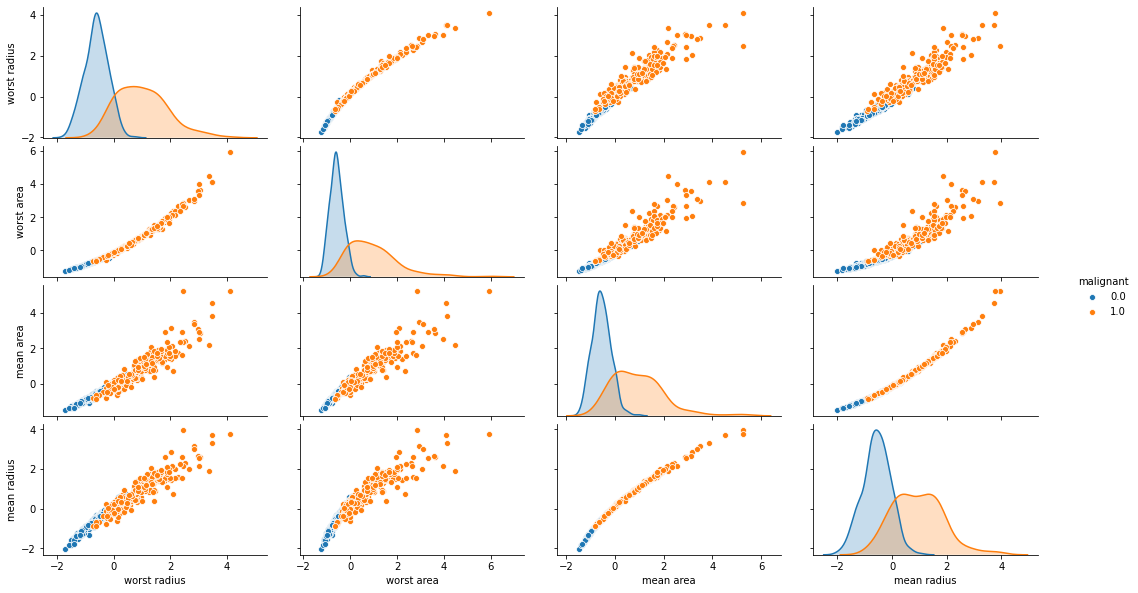

In [446]:
cols = ["malignant", 'worst radius','worst area', 'mean area', 'mean radius']
g = sns.pairplot(cancer_df.loc[:, cols], hue="malignant")
g.fig.set_figwidth(16)
g.fig.set_figheight(8);

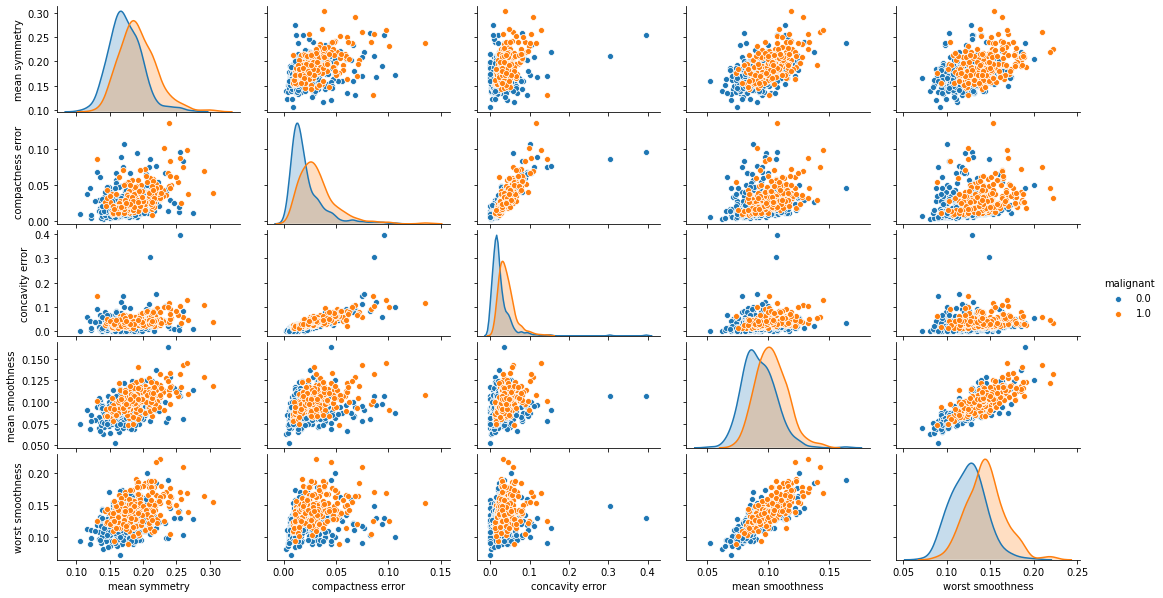

In [448]:
cols = ["malignant", "mean symmetry","compactness error", "concavity error", "mean smoothness", "worst smoothness"]
g = sns.pairplot(cancer_df.loc[:, cols], hue="malignant")
g.fig.set_figwidth(16)
g.fig.set_figheight(8);

In [449]:
print("PCA component shape: ", pca.components_.shape)

print(pca.components_)

PCA component shape:  (2, 30)
[[ 0.21890244  0.10372458  0.22753729  0.22099499  0.14258969  0.23928535
   0.25840048  0.26085376  0.13816696  0.06436335  0.20597878  0.01742803
   0.21132592  0.20286964  0.01453145  0.17039345  0.15358979  0.1834174
   0.04249842  0.10256832  0.22799663  0.10446933  0.23663968  0.22487053
   0.12795256  0.21009588  0.22876753  0.25088597  0.12290456  0.13178394]
 [-0.23385713 -0.05970609 -0.21518136 -0.23107671  0.18611302  0.15189161
   0.06016536 -0.0347675   0.19034877  0.36657547 -0.10555215  0.08997968
  -0.08945723 -0.15229263  0.20443045  0.2327159   0.19720728  0.13032156
   0.183848    0.28009203 -0.21986638 -0.0454673  -0.19987843 -0.21935186
   0.17230435  0.14359317  0.09796411 -0.00825724  0.14188335  0.27533947]]


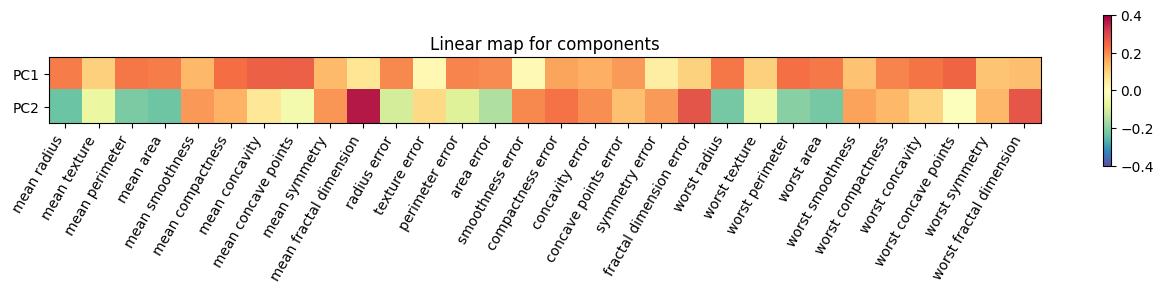

In [450]:
plt.figure(figsize=(16, 2), dpi=100)

ax = plt.gca()

pcs = pca.components_[:2, :]

import matplotlib.colors
norm = matplotlib.colors.Normalize(-0.4, 0.4)

im = ax.imshow(pcs, cmap=plt.cm.Spectral_r, norm=norm)
cbar = ax.figure.colorbar(im, ax=ax)

ax.set_xticks(range(len(cancer.feature_names)))
ax.set_xticklabels(cancer.feature_names, rotation=60, ha='right')
ax.set_yticks([0, 1])
ax.set_yticklabels(["PC1", "PC2"])

ax.set_title("Linear map for components");

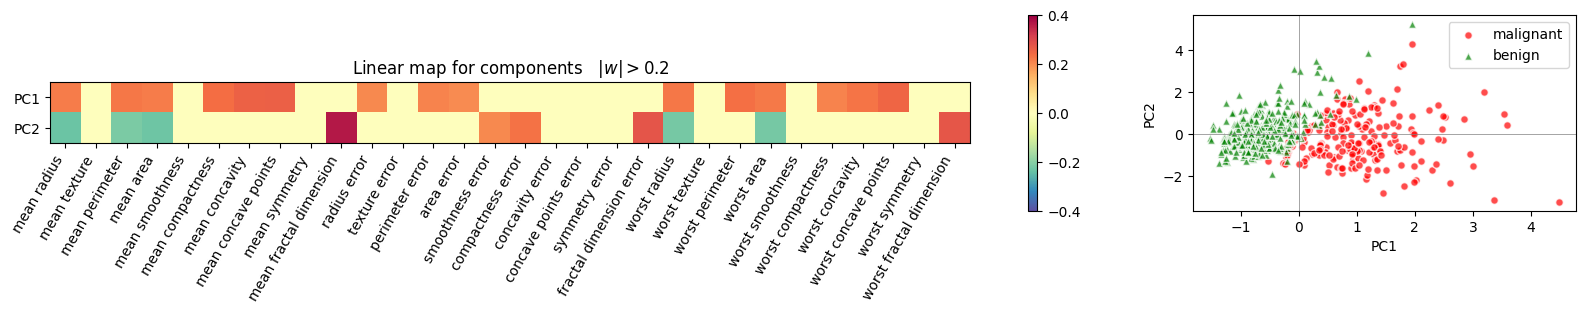

In [451]:
pca_ = PCA(n_components=2, whiten=True)
pca_.fit(X_scaled)
X_pca_ = pca_.transform(X_scaled)

pcs = pca_.components_[:2, :]
pcs[np.abs(pcs)<0.2] = 0 # 屏蔽小于0的数值

fig = plt.figure(figsize=(16, 3), dpi=100)

gspec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[3, 1])

ax = fig.add_subplot(gspec[0, 1])
ax.axhline(0, c="grey", lw=0.5); ax.axvline(0, c="grey", lw=0.5);
ax.scatter(X_pca_[cancer.target==1, 0], X_pca_[cancer.target==1, 1], 
            marker='o', s=30, ec="w", alpha=0.7, c="red", label=cancer.target_names[1])  
ax.scatter(X_pca_[cancer.target==0, 0], X_pca_[cancer.target==0, 1], 
            marker='^', s=30, ec="w", alpha=0.7, c="green", label=cancer.target_names[0])
ax.set_xlabel("PC1"); ax.set_ylabel("PC2");
ax.legend(loc="best")


ax = fig.add_subplot(gspec[0, 0])
import matplotlib.colors
norm = matplotlib.colors.Normalize(-0.4, 0.4)

im = ax.imshow(pcs, cmap=plt.cm.Spectral_r, norm=norm)
cbar = ax.figure.colorbar(im, ax=ax)

ax.set_xticks(range(len(cancer.feature_names)))
ax.set_xticklabels(cancer.feature_names, rotation=60, ha='right')
ax.set_yticks([0, 1])
ax.set_yticklabels(["PC1", "PC2"])

ax.set_title(r"Linear map for components   $|w|>0.2$");

plt.tight_layout();

1. 成分`PC1`,值越大越有可能是恶性肿瘤，各特征（feature）投射到该成分中的系数，半径直径面积的成分系数都正的且较大的
2. 成分`PC2`和`PC1`在半径、直径、面积等特征的投射成分系数正负号相反;
3. 成分`PC2`，肿瘤海岸线分形维度(fratal dimension)特征成分系数是较大的正值。
    > 海岸线分形维度$n$，放大3倍而长度放大4倍，$3^n=4$，维度$n=\log_{3}(4)\approx1.261$ 

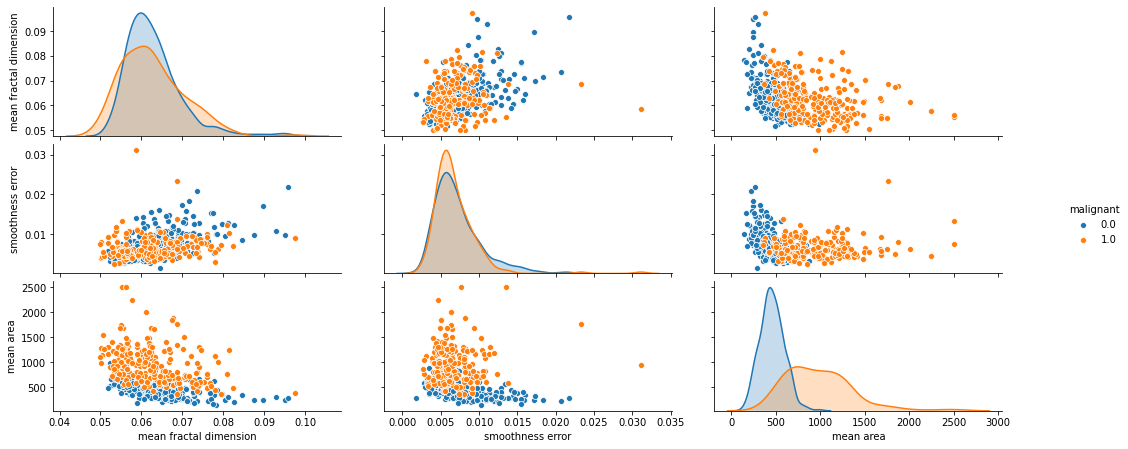

In [452]:
cols = ["malignant", "mean fractal dimension", "smoothness error", "mean area"]
g = sns.pairplot(cancer_df.loc[:, cols], hue="malignant")
g.fig.set_figwidth(16)
g.fig.set_figheight(6);

In [403]:
# X_scaled[:,feature_idxs] @ pca_.components_[:1, feature_idxs].T

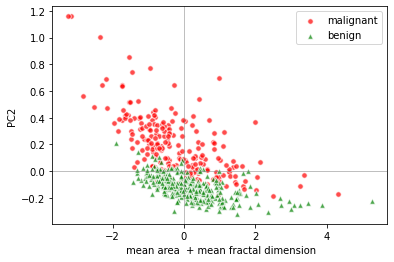

In [454]:
feature_idxs = [list(cancer.feature_names).index(name) for name in ["mean area", "mean fractal dimension"]]


X_pc1_ = X_scaled[:,feature_idxs] @ pca_.components_[:1, feature_idxs].T

ax = plt.gca()
# ax = fig.add_subplot(gspec[0, 1])
ax.axhline(0, c="grey", lw=0.5); ax.axvline(0, c="grey", lw=0.5);
ax.scatter(X_pca_[cancer.target==1, 1], X_pc1_[cancer.target==1], 
            marker='o', s=30, ec="w", alpha=0.7, c="red", label=cancer.target_names[1])  
ax.scatter(X_pca_[cancer.target==0, 1], X_pc1_[cancer.target==0], 
            marker='^', s=30, ec="w", alpha=0.7, c="green", label=cancer.target_names[0])
ax.set_ylabel("PC2"); ax.set_xlabel(" mean area  + mean fractal dimension");
ax.legend(loc="best");

In [455]:
X_scaled @ pca.components_.T

array([[ 9.19283683,  1.94858307],
       [ 2.3878018 , -3.76817174],
       [ 5.73389628, -1.0751738 ],
       ...,
       [ 1.25617928, -1.90229671],
       [10.37479406,  1.67201011],
       [-5.4752433 , -0.67063679]])

In [456]:
np.abs(X_pca - X_scaled @ pca.components_.T).mean()

1.9496523610548617e-15

In [463]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

X = cancer.data
y = cancer.target

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('pca', PCA()), 
    ('svc', SVC(kernel='rbf'))
])


param_grid= {
    'pca__n_components': [2], 
    'svc__C': [0.1, 0.5, 1, 10, 50, 100, 500, 1000], 
    'svc__gamma' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]
}


from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=4)

grid = GridSearchCV(pipeline, scoring="f1", param_grid=param_grid, cv=cv)

grid.fit(X_train, y_train)

print(f"Best F1-score: {grid.best_score_: 0.3f} ")
print(f"       params: {grid.best_params_}")

Best F1-score:  0.928 
       params: {'pca__n_components': 2, 'svc__C': 10, 'svc__gamma': 0.01}


In [464]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

X = cancer.data
y = cancer.target

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('svc', SVC(kernel='rbf'))
])


param_grid= {
    'svc__C': [0.1, 0.5, 1, 10, 50, 100, 500, 1000], 
    'svc__gamma' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]
}


from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=4)

grid = GridSearchCV(pipeline, scoring="f1", param_grid=param_grid, cv=cv)

grid.fit(X_train, y_train)

print(f"Best F1-score: {grid.best_score_: 0.3f} ")
print(f"       params: {grid.best_params_}")

Best F1-score:  0.971 
       params: {'svc__C': 100, 'svc__gamma': 0.001}


In [465]:
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('pca', PCA(n_components=2))
])

pipeline.fit(X_train, y_train)

model = SVC(kernel="rbf", C=10, gamma=0.01)
model.fit(pipeline.transform(X_train), y_train)

from sklearn.metrics import f1_score

score = f1_score(y_train, model.predict(pipeline.transform(X_train)))
print(f"F1 training: {score:0.3f}")

score = f1_score(y_test, model.predict(pipeline.transform(X_test)))
print(f"F1 testing: {score:0.3f}")

F1 training: 0.919
F1 testing: 0.920


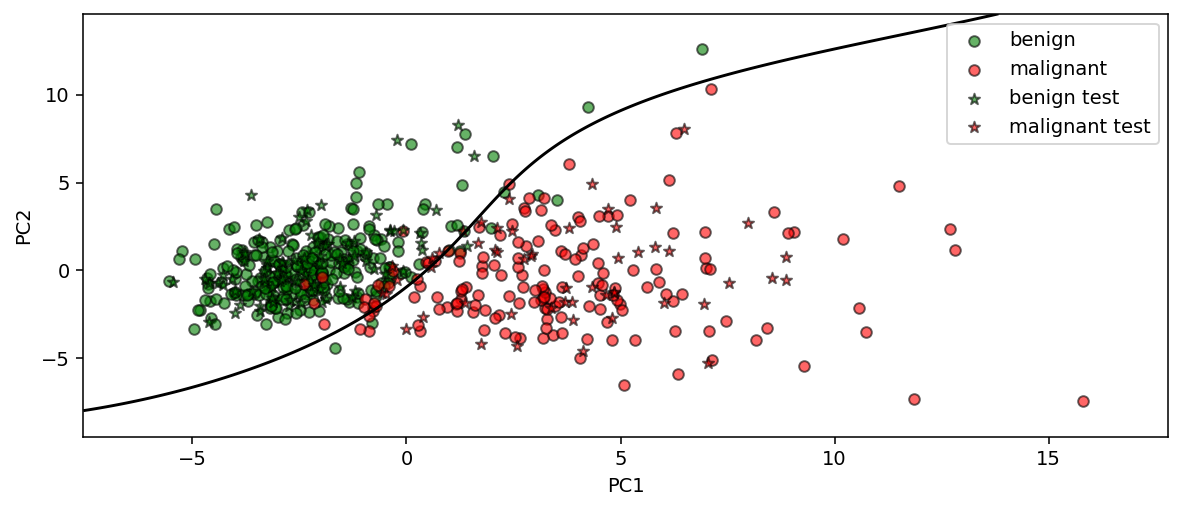

In [466]:
from plot_helper import plot_2d_separator

X_pca_train = pipeline.transform(X_train)
X_pca_test = pipeline.transform(X_test)

plt.figure(figsize=(10, 4), dpi=140)
ax = plt.gca()
plot_2d_separator(model, X_pca_train, eps=2, ax=ax)
ax.scatter(X_pca_train[y_train==0, 0], X_pca_train[y_train==0, 1], 
           label="benign", s=30, ec="k", c="green", alpha=0.6)
ax.scatter(X_pca_train[y_train==1, 0], X_pca_train[y_train==1, 1], 
           label="malignant", s=30, ec="k", c="red", alpha=0.6)
ax.scatter(X_pca_test[y_test==0, 0], X_pca_test[y_test==0, 1], 
           label="benign test", marker="*", c="green", ec="k", alpha=0.6)
ax.scatter(X_pca_test[y_test==1, 0], X_pca_test[y_test==1, 1], 
           label="malignant test", marker="*", c="red", ec="k", alpha=0.6)
ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
ax.legend();

## 特征脸(Eigenfaces)

In [330]:
from sklearn.datasets import fetch_lfw_people

people = fetch_lfw_people(data_home='../contrib_data', min_faces_per_person=20, resize=0.7)

image_shape = people.images[0].shape

In [468]:
image_shape

(87, 65)

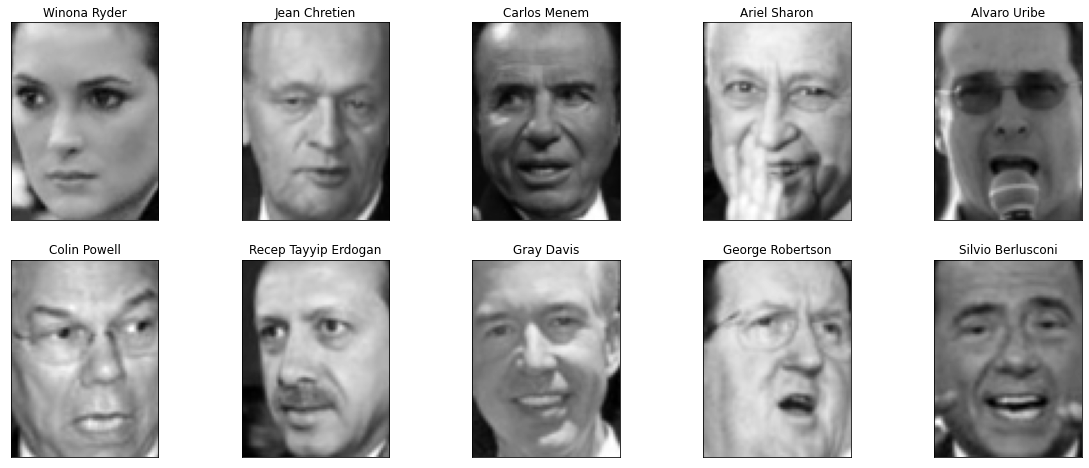

In [331]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(20, 8), subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image, cmap='gray')
    ax.set_title(people.target_names[target])

In [332]:
print("people.images.shape: ", people.images.shape)
print("Number of classes: ", len(people.target_names))

people.images.shape:  (3023, 87, 65)
Number of classes:  62


In [333]:
print("每一类样本的数量: \n")
counts = np.bincount(people.target)
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print(f"{name:25} {count:3}", end='     ')
    if (i + 1) % 4 == 0:
        print()

每一类样本的数量: 

Alejandro Toledo           39     Alvaro Uribe               35     Amelie Mauresmo            21     Andre Agassi               36     
Angelina Jolie             20     Ariel Sharon               77     Arnold Schwarzenegger      42     Atal Bihari Vajpayee       24     
Bill Clinton               29     Carlos Menem               21     Colin Powell              236     David Beckham              31     
Donald Rumsfeld           121     George Robertson           22     George W Bush             530     Gerhard Schroeder         109     
Gloria Macapagal Arroyo    44     Gray Davis                 26     Guillermo Coria            30     Hamid Karzai               22     
Hans Blix                  39     Hugo Chavez                71     Igor Ivanov                20     Jack Straw                 28     
Jacques Chirac             52     Jean Chretien              55     Jennifer Aniston           21     Jennifer Capriati          42     
Jennifer Lopez             21

In [1]:
87*65

5655

In [354]:
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1 # 每类最多50个样本
    
X_people, y_people = people.data[mask], people.target[mask]
X_people = X_people / 255 # 将颜色值（0~255）转换到0~1范围

In [356]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, stratify=y_people, random_state=0)

model_knn = KNeighborsClassifier(n_neighbors=1)
model_knn.fit(X_train, y_train)

score = accuracy_score(y_test, model_knn.predict(X_test))
print(f"Test set score of 1-nn: {score :.2f}")

Test set score of 1-nn: 0.23


**白化**(whiten)是一种重要的预处理过程，其目的就是降低输入数据的冗余性，使得经过白化处理的输入数据具有如下性质：
1. 特征之间相关性较低；
2. 所有特征具有相同的方差，PCA白化保证数据各维度的方差为1。。

如果训练数据是图像，由于图像中相邻像素之间具有很强的相关性，这些用于训练时输入是冗余的，因此，应用白化降低输入的冗余性。



In [1]:
pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca  = pca.transform(X_test)

print("X_train_pca.shape: {}".format(X_train_pca.shape))

NameError: name 'PCA' is not defined

In [358]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, y_train)
print("Test set accuracy: {:.2f}".format(knn.score(X_test_pca, y_test)))

Test set accuracy: 0.31


pca.components_.shape: (100, 5655)



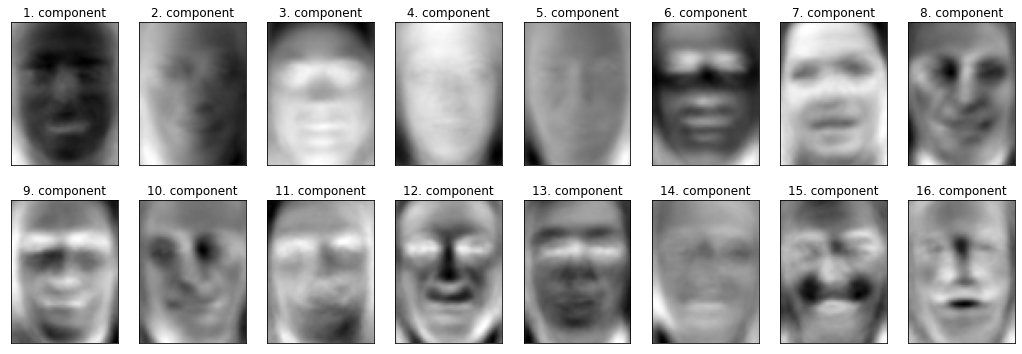

In [391]:
print(f"pca.components_.shape: {pca.components_.shape}\n")

fig, axes = plt.subplots(2, 8, figsize=(18, 6),
                         subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape), cmap='gray')
    ax.set_title("{}. component".format((i + 1)))

In [382]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

image_shape = people.images[0].shape
plt.figure(figsize=(20, 3), dpi=300)
ax = plt.gca()

imagebox = OffsetImage(people.images[0], zoom=1, cmap="gray")
ab = AnnotationBbox(imagebox, (.05, 0.4), pad=0.0, xycoords='data')
ax.add_artist(ab)

for i in range(4):
    imagebox = OffsetImage(pca.components_[i].reshape(image_shape), zoom=1,
                           cmap="viridis")

    ab = AnnotationBbox(imagebox, (.3 + .2 * i, 0.4),
                        pad=0.0,
                        xycoords='data'
                        )
    ax.add_artist(ab)
    if i == 0:
        plt.text(.18, .25, 'x_{} *'.format(i), fontdict={'fontsize': 50})
    else:
        plt.text(.15 + .2 * i, .25, '+ x_{} *'.format(i),
                 fontdict={'fontsize': 50})

plt.text(.95, .25, '+ ...', fontdict={'fontsize': 50})

plt.text(.13, .3, r'\approx', fontdict={'fontsize': 50})
plt.axis("off")
plt.savefig("images/03-face_decomposition12.png")
plt.close()


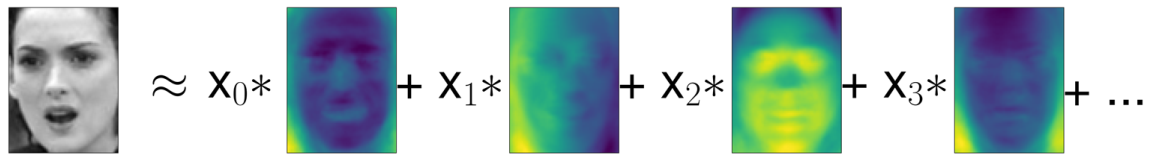

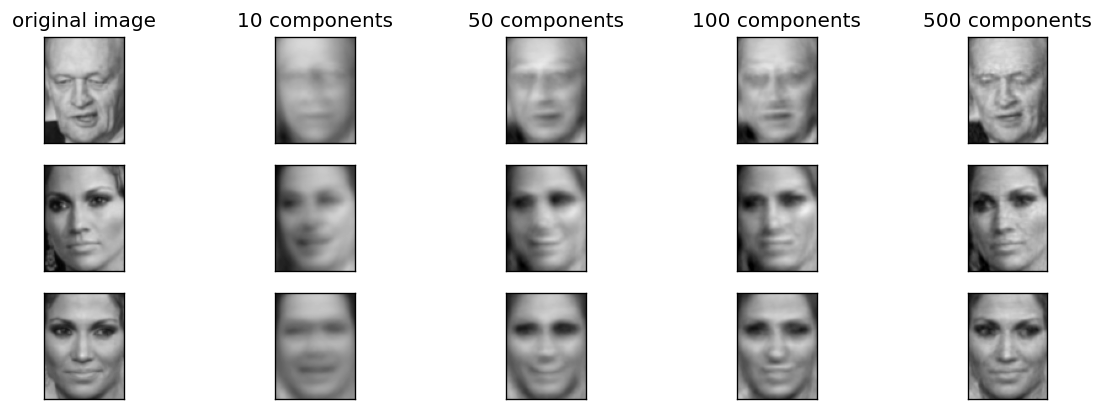

In [390]:
def plot_pca_faces(X_train, X_test, image_shape):
    reduced_images = []
    for n_components in [10, 50, 100, 500]:
        pca = PCA(n_components=n_components)
        pca.fit(X_train)
        X_test_pca = pca.transform(X_test)
        X_test_back = pca.inverse_transform(X_test_pca)
        reduced_images.append(X_test_back)
    
    fix, axes = plt.subplots(3, 5, figsize=(12, 4), dpi=120,
                             subplot_kw={'xticks': (), 'yticks': ()})
    for i, ax in enumerate(axes):
        ax[0].imshow(X_test[i].reshape(image_shape), vmin=0, vmax=1, cmap='gray')
        for a, X_test_back in zip(ax[1:], reduced_images):
            a.imshow(X_test_back[i].reshape(image_shape), vmin=0, vmax=1, cmap='gray')

    # label the top row
    axes[0, 0].set_title("original image")
    for ax, n_components in zip(axes[0, 1:], [10, 50, 100, 500]):
        ax.set_title("%d components" % n_components)
    
    fig.tight_layout()

plot_pca_faces(X_train, X_test, image_shape)

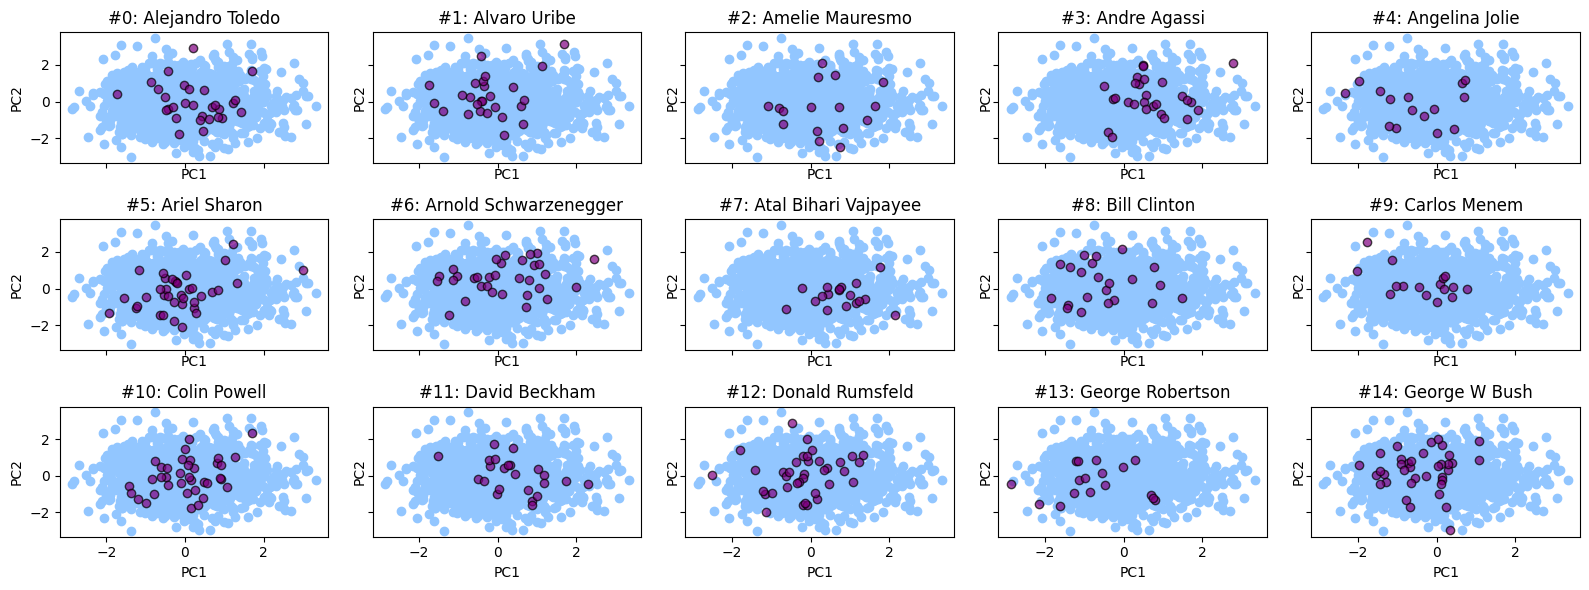

In [381]:
fig, axes = plt.subplots(3, 5, figsize=(16, 6), dpi=100, sharex=True, sharey=True)
axes = axes.ravel()
for i, ax in enumerate(axes):
    ax.scatter(X_train_pca[y_train!=i, 0], X_train_pca[y_train!=i, 1])
    ax.scatter(X_train_pca[y_train==i, 0], X_train_pca[y_train==i, 1], c="purple", ec="k", alpha=0.7)
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
    ax.set_title(f"#{i}: {people.target_names[i]}")
    
fig.tight_layout();


## Kernel PCA

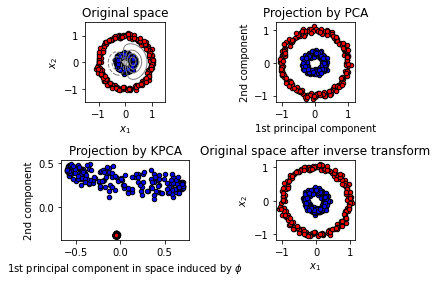

In [182]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles

np.random.seed(0)

X, y = make_circles(n_samples=400, factor=.3, noise=.05)

kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=10)
X_kpca = kpca.fit_transform(X)
X_back = kpca.inverse_transform(X_kpca)

pca = PCA()
X_pca = pca.fit_transform(X)

# Plot results

plt.figure()
plt.subplot(2, 2, 1, aspect='equal')
plt.title("Original space")
reds = y == 0
blues = y == 1

plt.scatter(X[reds, 0], X[reds, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(X[blues, 0], X[blues, 1], c="blue",
            s=20, edgecolor='k')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

X1, X2 = np.meshgrid(np.linspace(-1.5, 1.5, 50), np.linspace(-1.5, 1.5, 50))
X_grid = np.array([np.ravel(X1), np.ravel(X2)]).T
# projection on the first principal component (in the phi space)
Z_grid = kpca.transform(X_grid)[:, 0].reshape(X1.shape)
plt.contour(X1, X2, Z_grid, colors='grey', linewidths=1, origin='lower')

plt.subplot(2, 2, 2, aspect='equal')
plt.scatter(X_pca[reds, 0], X_pca[reds, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(X_pca[blues, 0], X_pca[blues, 1], c="blue",
            s=20, edgecolor='k')
plt.title("Projection by PCA")
plt.xlabel("1st principal component")
plt.ylabel("2nd component")

plt.subplot(2, 2, 3, aspect='equal')
plt.scatter(X_kpca[reds, 0], X_kpca[reds, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(X_kpca[blues, 0], X_kpca[blues, 1], c="blue",
            s=20, edgecolor='k')
plt.title("Projection by KPCA")
plt.xlabel(r"1st principal component in space induced by $\phi$")
plt.ylabel("2nd component")

plt.subplot(2, 2, 4, aspect='equal')
plt.scatter(X_back[reds, 0], X_back[reds, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(X_back[blues, 0], X_back[blues, 1], c="blue",
            s=20, edgecolor='k')
plt.title("Original space after inverse transform")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.tight_layout()
plt.show()